In [101]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, exp
from scipy.integrate import odeint
import scipy.special as sc

#Test de push

#Fonctions de conversion utiles
def s2day(t) :
    '''Conversion de t en seconde vers t en jours'''
    return t/(3600*24)

def s2year(t) :
    '''Conversion de t en seconde vers t en années'''
    return t/(3600*24*365)

In [102]:
#Constantes physiques
c = 3.e+8           #Vitesse de la lumière 
h = 6.626e-34       #Planck
kb = 1.380e-23      #Boltzmann
Jy = 10.e-26        #1 jansky en SI
sigma = 5.67e-8     #constante de Stefan
a = 4*sigma/c

#Constantes pour le soleil
M_sun = 1.989e+30
R_sun = 696340e+3
L_sun = 3.827e+26


#Paramètre pour le terme de chauffage
A = 6.6e+42/M_sun   
alpha = 1.3

In [103]:
#Constantes du problème
M_ej = 1.e-2*M_sun  #Masse éjectée
v_exp = 0.15*c      #Vitesse d'expension 
R_0 = 1.e+4         #Rayon initial
kappa = 0.5         #Opacité


#Constantes du model 
k1 = 1.             #Ajustement du model pour temps radiatif 

In [104]:
#Calcul des temps et longueurs caractéristiques
t_star = sqrt(3*M_ej*kappa/(4*pi*c*v_exp))
R_neb = sqrt(3*M_ej*kappa/(4*pi))
t_neb = R_neb/v_exp

print("Constantes caractéristiques du probleme :")
print("t* = " + str("%.2e"%t_star) + " s = " + str("%.2f"%s2day(t_star)) + " jours")
print("t_neb = " + str("%.2e"%t_neb) + " s = " + str("%.2f"%s2day(t_neb)) + " jours")
print("R_neb = " + str("%.2e"%R_neb) + " m = " + str("%.2f"%(R_neb/R_sun)) + " Rayons solaire")

Constantes caractéristiques du probleme :
t* = 4.19e+05 s = 4.85 jours
t_neb = 1.08e+06 s = 12.53 jours
R_neb = 4.87e+13 m = 69974.01 Rayons solaire


In [105]:
def R(t) :
    return v_exp*t 

def l_bar(t) :
    rho = 3*M_ej/(4*pi*pow(R(t),3))
    return 1/(rho*kappa)

def T_list(t_list) :
    res = []
    for i in range(len(t_list)) :
        t = t_list[i]
        L_t = L[i]
        T_t = pow(L_t/(4*pi*R(t)*l_bar(t)),1/4)
        res+= [T_t]
    return res
        
def Ts_list(t_list) :
    res=[]
    T = T_list(t_list)
    for i in range(len(t_list)) :
        t = t_list[i]
        T_t = T[i]
        Ts_t = pow(l_bar(t)/R(t),1/4)*T_t
        res+= [Ts_t]
    return res

def E_dot(t) :
    return A*M_ej*pow(t,-alpha)

In [106]:

def P(t) :
    return a*T(t)/3

def U(t) : 
    return 4*pi*a*pow(R(t),3)*pow(T(t),4)/3


    
def L(t) :
    return 4*pi*pow(R(t),2)*sigma*pow(Ts(t),4)



### Equation d'évolution de l'ejecta dans la phase d'expansion libre : 
L'équation à résoudre est :

$t_{rad}\frac{dL}{dt} + L(t) = \dot E(t)$

Nous utiliserons odeint de numpy pour sa résolution numérique.

In [107]:
def model(L,t) :
    dLdt = (E_dot(t)-L)*k1*t/pow(t_star,2)
    return dLdt


t = np.linspace(1.e-6, 1.3*int(t_neb), num=10000)
L0 = 0
L = odeint(model, L0, t)


In [108]:
#Expression analytique pour L 
#Ne marche pas ? 

def L_analytique(t) :
    a = pow(t_star,2)
    b = A*M_ej/a
    c = alpha-1
    return a*b*pow(2,1/(2*(-c-1)))*exp(-pow(t,2)/(2*a))*pow(t,-c-1)*pow(-pow(t,2)/a,(c+1)/2)*sc.gammainc((1-c)/2,-pow(t,2)/(2*a))

print(L_analytique(20000))

(nan+nanj)


In [109]:
#Expression de l'intensité spécifique (dans un modèle de corps noir)

def B(nu,Ts_list):
    res = []
    for i in range(len(Ts_list)) :
        Ts = Ts_list[i]
        Bnu = (2*h*pow(nu,3)/pow(c,2)) / (np.exp((h*nu)/(kb*Ts)) - 1)
        res+= [Bnu]
    return res

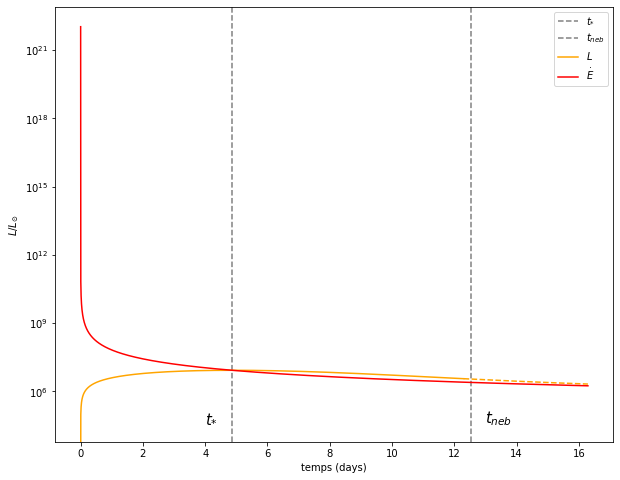

In [110]:
Nlim = 7550

plt.figure(figsize=[10,8])
plt.yscale('log')
plt.xlabel('temps (days)')
plt.ylabel('$L/L_{\odot }$')
plt.axvline(x=s2day(t_star),color='gray',linestyle='--',label='$t_{*}$')
plt.axvline(x=s2day(t_neb),color='gray',linestyle='--',label='$t_{neb}$')
plt.plot(s2day(t[:Nlim]),L[:Nlim]/L_sun,color='orange', label='$L$')

plt.plot(s2day(t[Nlim:]),L[Nlim:]/L_sun,linestyle='--',color='orange')
plt.text(int(s2day(t_star)),4.e+4,'$t_{*}$',fontsize=15)
plt.text(int(s2day(t_neb)) + 1,4.e+4,'$t_{neb}$',fontsize=15)

plt.plot(s2day(t), E_dot(t)/L_sun, color='red', label='$\dot{E}$')
#plt.plot(s2day(t), [L_analytique(ti)/L_sun for ti in t], color='red', label='L analytique')
plt.legend(loc="upper right")

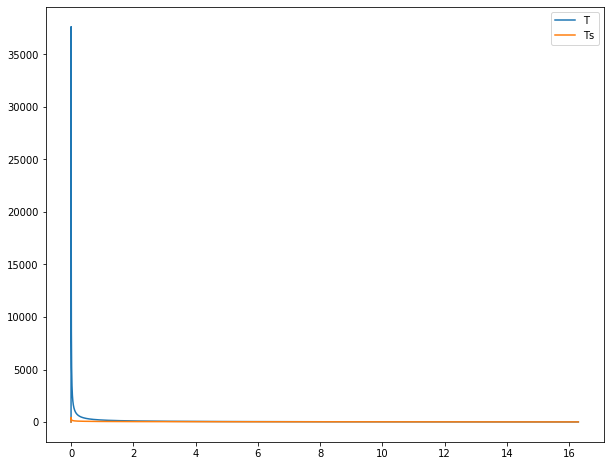

In [111]:
plt.figure(figsize=[10,8])
T = T_list(t)
Ts = Ts_list(t)
plt.plot(s2day(t[00:]),T[00:],label='T')
plt.plot(s2day(t[00:]),Ts[00:],label='Ts')
plt.legend()


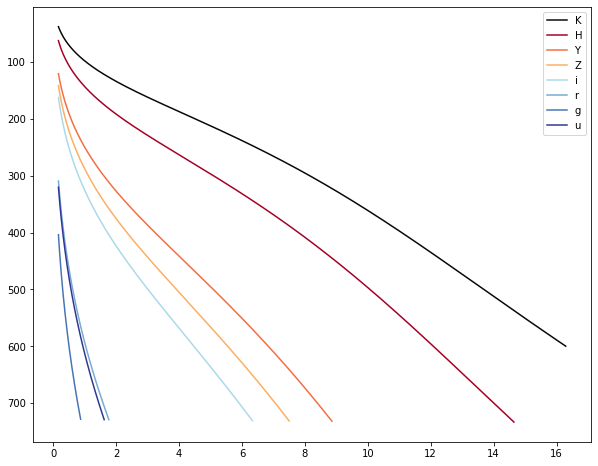

In [112]:
#Longueurs d'ondes et légendes correspondantes
lambd = [2190e-9,1630e-9,1020e-9,900e-9,806e-9,464e-9,365e-9,450e-9]
lettres = ['K','H','Y','Z','i','r','g','u']
colors = [ [8/255,8/255,8/255], [165/255,0/255,38/255], [244/255,109/255,67/255], [253/255,174/255,97/255], [171/255,217/255,233/255], [116/255,173/255,209/255], [69/255,117/255,180/255], [49/255,54/255,149/255] ]

plt.figure(figsize=[10,8])

for i in range(len(lambd)):

    #Intensité spécifique
    nu = c/lambd[i]
    Bnu = B(nu,Ts)

    #Conversion en jansky et en magnitude AB
    #TODO Verfier le pi pour transformer l'intensité spécifique en densité de flux
    magAB = [-2.5*np.log( pi*Bnu[i]/(3631*Jy) )/np.log(10) for i in range(len(Bnu))]

    plt.plot(s2day(t[100:]),magAB[100:],label=lettres[i], color=colors[i])

plt.gca().invert_yaxis()
plt.legend()